GPyTorch Experiments
---
An extremely messy development notebook. Working out how GPyTorch is wired, pulling out various cables, plugging them into the Matern 5/2 derivative from the GPFlow notebook.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pdb

from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, ProductKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [101]:
#Same Random data at the gpflow example, but its in pytorch tensors.
freq = 10

#This is just for plotting
Xexact = torch.linspace(0,2,100)
Yexact = torch.sin(Xexact*freq)
dYdXexact = freq*torch.cos(Xexact*freq)

#This is what will go into the GP fit
Ndata = 1000
sigma = 0.1
Xdata = 2*torch.rand(Ndata)
Ydata = torch.sin(Xdata * freq) + sigma * torch.randn(Ndata)
sigdata = 0.1*torch.ones(Ndata) + torch.abs(sigma * torch.randn(Ndata))

In [102]:
Ydata.shape

torch.Size([1000])

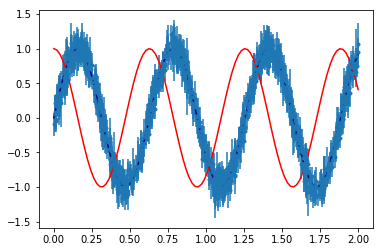

In [103]:
plt.errorbar(Xdata.numpy(), Ydata.numpy(), yerr=sigdata.numpy(),fmt='.')
plt.plot(Xexact.numpy(),Yexact.numpy(),color='navy')
plt.plot(Xexact.numpy(),dYdXexact.numpy()/10,color='red')

### Build the Model

In [104]:
%reload_ext autoreload
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = ScaleKernel(ProductKernel(MaternKernel(nu=2.5,
                            active_dims=torch.tensor([0]))))#
        #Needs the Product Kernel so the kernels get indices
        #self.covar_module = MaternKernel(nu=2.5)#
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
                noise=sigdata**2, learn_additional_noise=False)
model = ExactGPModel(Xdata, Ydata, likelihood)

### Train the Model

In [105]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
            {'params': model.parameters()},  # Includes GaussianLikelihood parameters
            ], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(Xdata)
    # Calc loss and backprop gradients
    loss = -mll(output, Ydata)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item()
#         ))
    optimizer.step()

### Derivative of Matern 5/2 Kernel

In [106]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

FixedNoiseGaussianLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (noise_covar): FixedGaussianNoise()
)

In [107]:
model

ExactGPModel(
  (likelihood): FixedNoiseGaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): MaternKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [108]:
#N data points
#M test points
#D dimensions 

#Extract data X values
model.train_inputs[0].shape #X input data values, NxD
model.train_targets.shape # Y data values, N

torch.Size([1000])

In [109]:
#Extract sigmas 
model.likelihood.noise_covar.noise.shape  # variances

torch.Size([1000])

In [110]:
#Extract kernel variances
model.covar_module.outputscale #I think this is it

tensor(1.4182, grad_fn=<SoftplusBackward>)

In [111]:
#Extract KXX
KXXinv = model.covar_module.base_kernel(Xdata.reshape(-1,1),Xdata.reshape(-1,1))\
        .add_diag(model.likelihood.noise_covar.noise).evaluate().inverse()

In [112]:
model.covar_module.base_kernel.lengthscale

In [113]:
model.covar_module.base_kernel.kernels[0].lengthscale

tensor([[0.3112]], grad_fn=<SoftplusBackward>)

In [114]:
#Calculate alpha
alpha = torch.matmul(KXXinv, model.train_targets)

In [115]:
#torch.stack([kernel.lengthscale[0,0] for kernel in model_2D.covar_module.base_kernel.kernels])

In [116]:
Xtest1 = torch.Tensor([1.5])
Xtest1

tensor([1.5000])

In [117]:
kxX = model.covar_module.base_kernel(Xtest1.reshape(-1,1),Xdata.reshape(-1,1))

In [118]:
kxX.evaluate().shape[1]

1000

In [119]:
#Extract lengthscales
model.covar_module.base_kernel.lengthscale #Dx1 or 1xD

In [120]:
torch.diag(1/(torch.Tensor([1,2,3])**2))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.0000],
        [0.0000, 0.0000, 0.1111]])

In [121]:
def dfdx_calc_Matern52(model, Xstar_list):
    
    # M test points
    # N data points
    # D dimensions

    KXXinv = model.covar_module.base_kernel(model.train_inputs[0],
                                            model.train_inputs[0])\
                .add_diag(model.likelihood.noise_covar.noise).evaluate().inverse() #NxN
     
    alpha = torch.matmul(KXXinv, model.train_targets).reshape(-1,1) #Nx1
    
    kxX_list = torch.stack([model.covar_module.base_kernel(Xstarii.reshape(1,-1),
                    model.train_inputs[0]).evaluate()\
                    for Xstarii in Xstar_list]) #MxDxN
    
    #Recreate the fstar for testing
    fstar_list = torch.stack([torch.matmul(kxX_list[ii],alpha) for ii in range(kxX_list.shape[0])])
        
    #Inverse Lengthscale Matrix Lambda DxD
    #InvLambda = torch.diag(1/(model.covar_module.base_kernel.lengthscale**2)) #DxD
    InvLambda = torch.stack([1/kernel.lengthscale[0,0]**2\
                  for kernel in model.covar_module.base_kernel.kernels]).diag()
    
    #Xtilde Calculation #MxNxD
    Xtilde = torch.stack([Xstarii - model.train_inputs[0]\
                          for Xstarii in Xstar_list]) #MxNxD
    
    #R_Lambda Calculation #MxN
    R_Lambda = torch.zeros([Xtilde.shape[0],Xtilde.shape[1]]) #MxN
    for ii in range(Xtilde.shape[0]):
        for jj in range(Xtilde.shape[1]):
            R_Lambda[ii,jj] = torch.sqrt(torch.matmul(Xtilde[ii,jj].reshape(-1,1).t(), 
                                torch.matmul(InvLambda,Xtilde[ii,jj].reshape(-1,1))))
    #try torch.bmm()            
    
#   dk(x,X)/dx calculation DxN
    kernel_variances = 1. 
    dkxX_dx = torch.stack([kernel_variances\
                *(-(5/3) * torch.matmul(InvLambda,Xtilde[ii].t())\
                          *(torch.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).t()\
                  -(5*np.sqrt(5)/3) * torch.matmul(InvLambda,Xtilde[ii].t()) \
                          *R_Lambda[ii]*(torch.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).t()\
                 ) for ii in range(Xtilde.shape[0])])
    
    # Mean dfdx calculation MxD
    mean_dfdx = torch.stack([torch.matmul(dkxX_dx[ii],alpha) for ii in range(Xtilde.shape[0])])
    
    
    pdb.set_trace()
    
    # Variance df/dx calculation MxDxD
    covar_dfdx = torch.stack([(5/3)*kernel_variances*InvLambda\
                    - torch.matmul(dkxX_dx[ii],torch.matmul(KXXinv, dkxX_dx[ii].t()))
                    for ii in range(Xtilde.shape[0])]) 
    #- torch.matmul(dkxX_dx[ii],torch.matmul(KXXinv, dkxX_dx[ii].t()))
    pdb.set_trace()

# R_Lambda Calculation MxN
#     R_Lambda = np.zeros([Xtilde.shape[0],Xtilde.shape[1]]) #MxN
#     for ii in range(Xtilde.shape[0]):
#         for jj in range(Xtilde.shape[1]):
#             R_Lambda[ii,jj] = np.sqrt(np.linalg.multi_dot([Xtilde[ii,jj].reshape(-1,1).T,InvLambda,
#                                                    Xtilde[ii,jj].reshape(-1,1)]))

#     # dk(x,X)/dx calculation DxN
#     dkxX_dx = np.array([kernel_variances\
#                 *(-(5/3) * np.matmul(InvLambda,Xtilde[ii].T)\
#                           *(np.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).T\
#                   -(5*np.sqrt(5)/3) * np.matmul(InvLambda,Xtilde[ii].T) \
#                           *R_Lambda[ii]*(np.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).T\
#                  ) for ii in range(Xtilde.shape[0])])

#     # Mean df/dx calculation
#     mean_dfdx_list = [np.dot(dkxX_dx[ii],alpha) for ii in range(Xtilde.shape[0])]

#     # Variance df/dx calculation
#     covar_dfdx_list = [(5/3) * kernel_variances * InvLambda \
#                        - np.linalg.multi_dot([dkxX_dx[ii], KXXinv, dkxX_dx[ii].T])\
#                     for ii in range(Xtilde.shape[0])] 
    

    return fstar_list, mean_dfdx, covar_dfdx

In [122]:
# x1 = torch.Tensor([[0,0],[1,1],[2,2]])
# x2 = torch.Tensor([[3,4],[7,3]])
# model.covar_module.base_kernel.covar_dist(Xdata.reshape(-1,1),Xtest.reshape(-1,1)).shape

### Plot Results

In [123]:
#Test points
Xtest = torch.linspace(0,2,120)

In [124]:
fstar_test, mean_dfdx, covar_dfdx = dfdx_calc_Matern52(model, Xtest)

> <ipython-input-121-3fc3ff8deef1>(45)dfdx_calc_Matern52()
-> covar_dfdx = torch.stack([(5/3)*kernel_variances*InvLambda                    - torch.matmul(dkxX_dx[ii],torch.matmul(KXXinv, dkxX_dx[ii].t()))
(Pdb) c
> <ipython-input-121-3fc3ff8deef1>(74)dfdx_calc_Matern52()
-> return fstar_list, mean_dfdx, covar_dfdx
(Pdb) c


In [125]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ftest = model(Xtest)

In [126]:
ftest_samples = ftest.sample(sample_shape=torch.Size([1]))

/home/hamish/anaconda3/lib/python3.6/site-packages/gpytorch/utils/cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter} to the diagonal", RuntimeWarning)


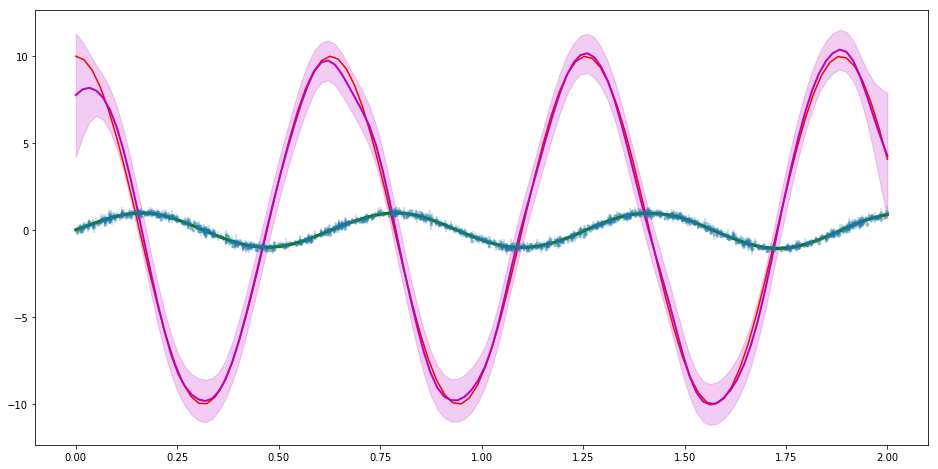

In [127]:
## plot 
plt.figure(figsize=(16, 8))
plt.plot(Xexact.numpy(),Yexact.numpy(),color='navy')
plt.errorbar(Xdata.numpy(), Ydata.numpy(), yerr=sigdata.numpy(),fmt='.',alpha=0.3)
plt.plot(Xtest.numpy(), ftest.mean.numpy(), lw=2, color='orange')

plt.plot(Xexact.numpy(),dYdXexact.numpy(),color='red')
plt.plot(Xtest.numpy(), mean_dfdx.detach().numpy().reshape(-1), lw=2, color='m')
plt.fill_between(Xtest.numpy(),
                 mean_dfdx.detach().numpy().reshape(-1) - 1.96 * np.sqrt(covar_dfdx.detach().numpy().reshape(-1)),
                 mean_dfdx.detach().numpy().reshape(-1) + 1.96 * np.sqrt(covar_dfdx.detach().numpy().reshape(-1)),
                 color='m', alpha=0.2)


# [plt.plot(Xtest.numpy(), ftest_sample.numpy(), lw=2, color='m')\
#  for ftest_sample in ftest_samples]
plt.plot(Xtest.numpy(), fstar_test.detach().numpy().reshape(-1), lw=3, color='green')

plt.fill_between(Xtest.numpy(),
                 ftest.mean.numpy() - 1.96 * np.sqrt(ftest.variance.detach().numpy()),
                 ftest.mean.numpy() + 1.96 * np.sqrt(ftest.variance.detach().numpy()),
                 color='orange', alpha=0.5)


### 2D Test

In [128]:
#Exact Input and Output Grids
freq1 = 2.0
freq2 = 6.0

X1_edges_exact = torch.linspace(-1,1,101)
X2_edges_exact = torch.linspace(-1,1,101)
X1_cents_exact = (X1_edges_exact[1:] - X1_edges_exact[:-1])/2 + X1_edges_exact[:-1]
X2_cents_exact = (X2_edges_exact[1:] - X2_edges_exact[:-1])/2 + X2_edges_exact[:-1]

X1_edges_mesh_exact, X2_edges_mesh_exact = torch.meshgrid(X1_edges_exact, X2_edges_exact)
X1_cents_mesh_exact, X2_cents_mesh_exact = torch.meshgrid(X1_cents_exact, X2_cents_exact)


Y_mesh_exact = torch.cos(freq1*X1_cents_mesh_exact) + torch.cos(freq2*X2_cents_mesh_exact)
dYdX1_mesh_exact = -freq1 * torch.sin(freq1*X1_cents_mesh_exact) 
dYdX2_mesh_exact = -freq2 * torch.sin(freq2*X2_cents_mesh_exact)

In [129]:
#Sample Input and Output Grids
Nsamps = 1000
Xdata2d = torch.rand((Nsamps,2))*2 - 1 
Ydata2d = (torch.cos(freq1*Xdata2d[:,0]) \
            + torch.cos(freq2*Xdata2d[:,1]) \
            + 0.1*torch.randn(Xdata2d.shape[0]))

#Uncertainties:
Ydata2d_sigma = 0.01*torch.randn(size=Ydata2d.shape) + 0.1

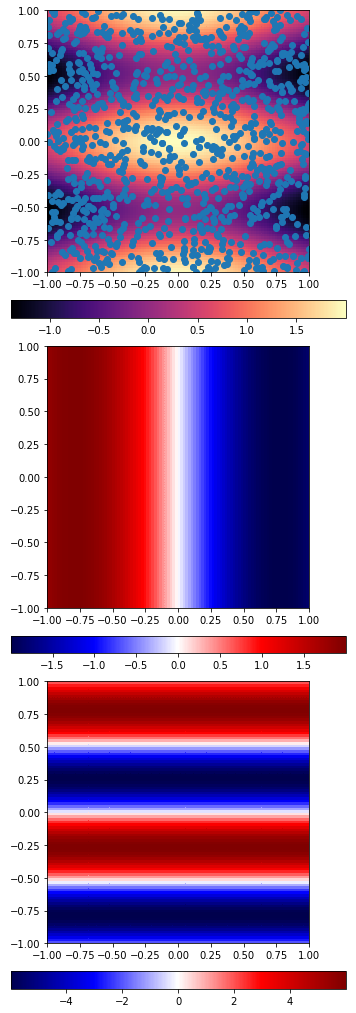

In [130]:
fig2d, ax2d = plt.subplots(ncols=1, nrows=6, gridspec_kw={"height_ratios":[15,1,15,1,15,1]})
fig2d.set_figheight(18)
fig2d.set_figwidth(6)

ax_im = ax2d[0]
ax_cbar = ax2d[1]

ax_dYdX1 = ax2d[2]
ax_dYdX1_cbar = ax2d[3]

ax_dYdX2 = ax2d[4]
ax_dYdX2_cbar = ax2d[5]


ax_im.set_aspect('equal')
ax_dYdX1.set_aspect('equal')
ax_dYdX2.set_aspect('equal')

im_Y_exact= ax_im.pcolormesh(X1_edges_mesh_exact.numpy(), X2_edges_mesh_exact.numpy(), 
                             Y_mesh_exact.numpy(), cmap='magma')
im_Y_dYdX1= ax_dYdX1.pcolormesh(X1_edges_mesh_exact.numpy(), X2_edges_mesh_exact.numpy(), 
                                dYdX1_mesh_exact.numpy(), cmap='seismic')
im_Y_dYdX2= ax_dYdX2.pcolormesh(X1_edges_mesh_exact.numpy(), X2_edges_mesh_exact.numpy(), 
                                dYdX2_mesh_exact.numpy(), cmap='seismic')

ax_im.scatter(Xdata2d.numpy()[:,0], Xdata2d.numpy()[:,1])

cb_exact = fig2d.colorbar(im_Y_exact, cax=ax_cbar,orientation='horizontal')
cb_dYdX1 = fig2d.colorbar(im_Y_dYdX1, cax=ax_dYdX1_cbar,orientation='horizontal')
cb_dYdX2 = fig2d.colorbar(im_Y_dYdX2, cax=ax_dYdX2_cbar,orientation='horizontal')
ax_im.set_xlim(-1,1)
ax_im.set_ylim(-1,1)
plt.show()

In [131]:
%reload_ext autoreload
# We will use the simplest form of GP model, exact inference
class ExactGPModel_2D(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel_2D, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=2.5, active_dims=torch.tensor([0]))\
                                        *MaternKernel(nu=2.5, active_dims=torch.tensor([1])))#
        #self.covar_module = RBFKernel(ard_num_dims=2)#
        #self.covar_module = MaternKernel(nu=2.5)#
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood_2D = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
                noise=Ydata2d_sigma**2, learn_additional_noise=False)
model_2D = ExactGPModel_2D(Xdata2d, Ydata2d, likelihood_2D)

In [132]:
# Find optimal model hyperparameters
model_2D.train()
likelihood_2D.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
            {'params': model_2D.parameters()},  # Includes GaussianLikelihood parameters
            ], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_2D, model_2D)

training_iter = 1000
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_2D(Xdata2d)
    # Calc loss and backprop gradients
    loss = -mll(output, Ydata2d)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item()
#         ))
    optimizer.step()

In [133]:
torch.stack([kernel.lengthscale[0,0]\
              for kernel in model_2D.covar_module.base_kernel.kernels])

tensor([3.6165, 1.0574], grad_fn=<StackBackward>)

In [134]:
#Define a new X grid over which to interpolate - XSTAR_grid
X1_edges_star = torch.linspace(-1,1,50)
X2_edges_star = torch.linspace(-1,1,50)
X1_cents_star = (X1_edges_star[1:] - X1_edges_star[:-1])/2 + X1_edges_star[:-1]
X2_cents_star = (X2_edges_star[1:] - X2_edges_star[:-1])/2 + X2_edges_star[:-1]

X1_edges_mesh_star, X2_edges_mesh_star = torch.meshgrid(X1_edges_star, X2_edges_star)
X1_cents_mesh_star, X2_cents_mesh_star = torch.meshgrid(X1_cents_star, X2_cents_star)

Xstar_points_2D = torch.stack([X1_cents_mesh_star.flatten(), X2_cents_mesh_star.flatten()]).t()

In [135]:
model_2D.eval()
likelihood_2D.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    fstar2d = model_2D(Xstar_points_2D)
    
fstar2d_mean = fstar2d.mean.reshape(X1_cents_mesh_star.shape)

In [136]:
ftest_2d, mean_dfdx_2d, covar_dfdx_2d = dfdx_calc_Matern52(model_2D,Xstar_points_2D)

> <ipython-input-121-3fc3ff8deef1>(45)dfdx_calc_Matern52()
-> covar_dfdx = torch.stack([(5/3)*kernel_variances*InvLambda                    - torch.matmul(dkxX_dx[ii],torch.matmul(KXXinv, dkxX_dx[ii].t()))
(Pdb) mean_dfdx.shape
torch.Size([2401, 2, 1])
(Pdb) covar_dfdx.shape
torch.Size([120, 1, 1])
(Pdb) n
> <ipython-input-121-3fc3ff8deef1>(46)dfdx_calc_Matern52()
-> for ii in range(Xtilde.shape[0])])
(Pdb) 
> <ipython-input-121-3fc3ff8deef1>(48)dfdx_calc_Matern52()
-> pdb.set_trace()
(Pdb) 
> <ipython-input-121-3fc3ff8deef1>(74)dfdx_calc_Matern52()
-> return fstar_list, mean_dfdx, covar_dfdx
(Pdb) 
(Pdb) covar_dfdx.shape
torch.Size([2401, 2, 2])
(Pdb) covar_dfdx[0]
tensor([[0.0056, 0.0087],
        [0.0088, 0.0326]], grad_fn=<SelectBackward>)
(Pdb) c


In [145]:
mean_dfdX1 = mean_dfdx_2d[:,0].reshape(X1_cents_mesh_star.shape).detach()
mean_dfdX2 = mean_dfdx_2d[:,1].reshape(X1_cents_mesh_star.shape).detach()

In [146]:
mean_dfdx1

tensor([[ 1.9481,  1.9634,  1.9548,  ...,  1.9348,  1.9604,  1.9626],
        [ 1.9223,  1.9399,  1.9337,  ...,  1.9142,  1.9388,  1.9396],
        [ 1.8911,  1.9109,  1.9071,  ...,  1.8885,  1.9120,  1.9114],
        ...,
        [-1.8478, -1.8571, -1.8449,  ..., -1.7047, -1.7269, -1.7272],
        [-1.8685, -1.8761, -1.8624,  ..., -1.7175, -1.7411, -1.7431],
        [-1.8849, -1.8907, -1.8755,  ..., -1.7263, -1.7513, -1.7550]],
       grad_fn=<AsStridedBackward>)

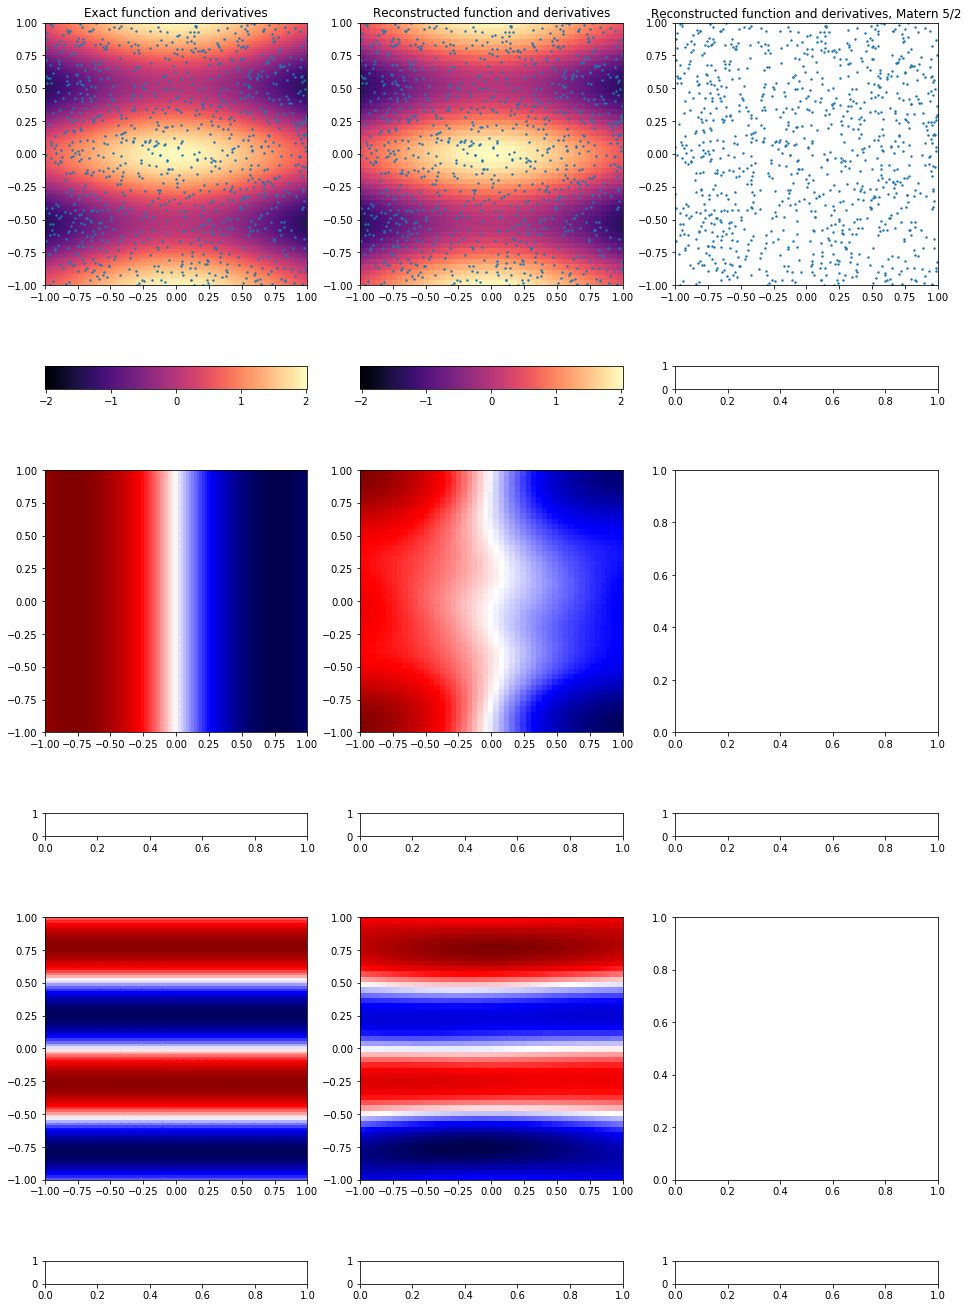

In [149]:
fig2d, ax2d = plt.subplots(ncols=3, nrows=6, gridspec_kw={"height_ratios":[15,1,15,1,15,1]})
fig2d.set_figheight(24)
fig2d.set_figwidth(16)

ax_im_exact = ax2d[0,0]
ax_cbar_exact = ax2d[1,0]
ax_dYdX1_exact = ax2d[2,0]
ax_dYdX1_exact_cbar = ax2d[3,0]
ax_dYdX2_exact = ax2d[4,0]
ax_dYdX2_exact_cbar = ax2d[5,0]

ax_im_star = ax2d[0,1]
ax_cbar_star = ax2d[1,1]
ax_dYdX1_star = ax2d[2,1]
ax_dYdX1_star_cbar = ax2d[3,1]
ax_dYdX2_star = ax2d[4,1]
ax_dYdX2_star_cbar = ax2d[5,1]

ax_im_star_mat = ax2d[0,2]
ax_cbar_star_mat = ax2d[1,2]
ax_dYdX1_star_mat = ax2d[2,2]
ax_dYdX1_star_cbar_mat = ax2d[3,2]
ax_dYdX2_star_mat = ax2d[4,2]
ax_dYdX2_star_cbar_mat = ax2d[5,2]


ax_im_exact.set_aspect('equal')
ax_dYdX1_exact.set_aspect('equal')
ax_dYdX2_exact.set_aspect('equal')

ax_im_star.set_aspect('equal')
ax_dYdX1_star.set_aspect('equal')
ax_dYdX2_star.set_aspect('equal')

ax_im_star_mat.set_aspect('equal')
ax_dYdX1_star_mat.set_aspect('equal')
ax_dYdX2_star_mat.set_aspect('equal')

fmean_maxmin = np.amax(abs(np.concatenate([Y_mesh_exact.numpy().flatten(), 
                                            fstar2d_mean.numpy().flatten()])))
mean_dfdX1_maxmin = np.amax(abs(np.concatenate([dYdX1_mesh_exact.numpy().flatten(), 
                                                 mean_dfdX1.numpy().flatten()]))) 
mean_dfdX2_maxmin = np.amax(abs(np.concatenate([dYdX2_mesh_exact.numpy().flatten(), 
                                                 mean_dfdX2.numpy().flatten()])))


im_Y_exact= ax_im_exact.pcolormesh(X1_edges_mesh_exact.numpy(), X2_edges_mesh_exact.numpy(), 
                                    Y_mesh_exact.numpy(), cmap='magma',
                                    vmin = -fmean_maxmin, vmax=fmean_maxmin)
im_Y_dYdX1_exact= ax_dYdX1_exact.pcolormesh(X1_edges_mesh_exact.numpy(), X2_edges_mesh_exact.numpy(), 
                                            dYdX1_mesh_exact, cmap='seismic',
                                            vmin = -mean_dfdX1_maxmin, vmax=mean_dfdX1_maxmin)
im_Y_dYdX2_exact= ax_dYdX2_exact.pcolormesh(X1_edges_mesh_exact.numpy(), X2_edges_mesh_exact.numpy(), 
                                            dYdX2_mesh_exact.numpy(), cmap='seismic',
                                            vmin = -mean_dfdX2_maxmin, vmax=mean_dfdX2_maxmin)

im_Y_star = ax_im_star.pcolormesh(X1_edges_mesh_star.numpy(), X2_edges_mesh_star.numpy(), 
                                  fstar2d_mean.numpy(), cmap='magma',
                                  vmin = -fmean_maxmin, vmax=fmean_maxmin)
im_Y_dYdX1_star = ax_dYdX1_star.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, 
                                           mean_dfdX1, cmap='seismic',
                                  vmin = -mean_dfdX1_maxmin, vmax=mean_dfdX1_maxmin)
im_Y_dYdX2_star = ax_dYdX2_star.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, 
                                           mean_dfdX2, cmap='seismic',
                                  vmin = -mean_dfdX2_maxmin, vmax=mean_dfdX2_maxmin)

# im_Y_star_mat = ax_im_star_mat.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, 
#                                           fmean_mesh_mat, cmap='magma',
#                                   vmin = -fmean_maxmin, vmax=fmean_maxmin)
# im_Y_dYdX1_star_mat = ax_dYdX1_star_mat.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, 
#                                                    mean_dfdX1_mesh_mat, cmap='seismic',
#                                   vmin = -mean_dfdX1_maxmin, vmax=mean_dfdX1_maxmin)
# im_Y_dYdX2_star_mat = ax_dYdX2_star_mat.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, 
#                                                    mean_dfdX2_mesh_mat, cmap='seismic',
#                                   vmin = -mean_dfdX2_maxmin, vmax=mean_dfdX2_maxmin)

ax_im_exact.scatter(Xdata2d.numpy()[:,0], Xdata2d.numpy()[:,1],s=2)
ax_im_star.scatter(Xdata2d.numpy()[:,0], Xdata2d.numpy()[:,1],s=2)
ax_im_star_mat.scatter(Xdata2d.numpy()[:,0], Xdata2d.numpy()[:,1],s=2)

ax_im_exact.set_title('Exact function and derivatives')
ax_im_star.set_title('Reconstructed function and derivatives')
ax_im_star_mat.set_title('Reconstructed function and derivatives, Matern 5/2')

cb_exact = fig2d.colorbar(im_Y_exact, cax=ax_cbar_exact,orientation='horizontal')
# cb_dYdX1_exact = fig2d.colorbar(im_Y_dYdX1_exact, cax=ax_dYdX1_exact_cbar,
#                                 orientation='horizontal')
# cb_dYdX2_exact = fig2d.colorbar(im_Y_dYdX2_exact, cax=ax_dYdX2_exact_cbar,
#                                 orientation='horizontal')

cb_star = fig2d.colorbar(im_Y_star, cax=ax_cbar_star,orientation='horizontal')
# cb_dYdX1_star = fig2d.colorbar(im_Y_dYdX1_star, cax=ax_dYdX1_star_cbar,
#                                orientation='horizontal')
# cb_dYdX2_star = fig2d.colorbar(im_Y_dYdX2_star, cax=ax_dYdX2_star_cbar,
#                                orientation='horizontal')

# cb_star_mat = fig2d.colorbar(im_Y_star_mat, cax=ax_cbar_star_mat,orientation='horizontal')
# cb_dYdX1_star_mat = fig2d.colorbar(im_Y_dYdX1_star_mat, cax=ax_dYdX1_star_cbar_mat,
#                                    orientation='horizontal')
# cb_dYdX2_star_mat = fig2d.colorbar(im_Y_dYdX2_star_mat, cax=ax_dYdX2_star_cbar_mat,
#                                    orientation='horizontal')

ax_im_exact.set_xlim(-1,1)
ax_im_exact.set_ylim(-1,1)
ax_im_star.set_xlim(-1,1)
ax_im_star.set_ylim(-1,1)
ax_im_star_mat.set_xlim(-1,1)
ax_im_star_mat.set_ylim(-1,1)
plt.show()

In [ ]:
test = torch.stack([kernel.lengthscale[0,0]\
                    for kernel in model_2D.covar_module.base_kernel.kernels])